# Unsupervised Learning

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

## Data

In [3]:
url = (
    'http://biostat.mc.vanderbilt.edu/' 
    'wiki/pub/Main/DataSets/titanic3.xls'
)

In [4]:
df = pd.read_excel(url)
df_orig = df.copy()

In [5]:
! python3 -m pip install --quiet category_encoders missingno yellowbrick

In [6]:
import category_encoders as ce

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [8]:
from sklearn.preprocessing import StandardScaler

### Preprocess data

In [9]:
df.isnull().shape

(1309, 14)

In [10]:
import missingno as mn

#### Drop leaky or low-information variables

In [11]:
df = df.drop(columns = ['survived', 'name', 'ticket', 'boat', 'body', 'cabin', 'home.dest'])

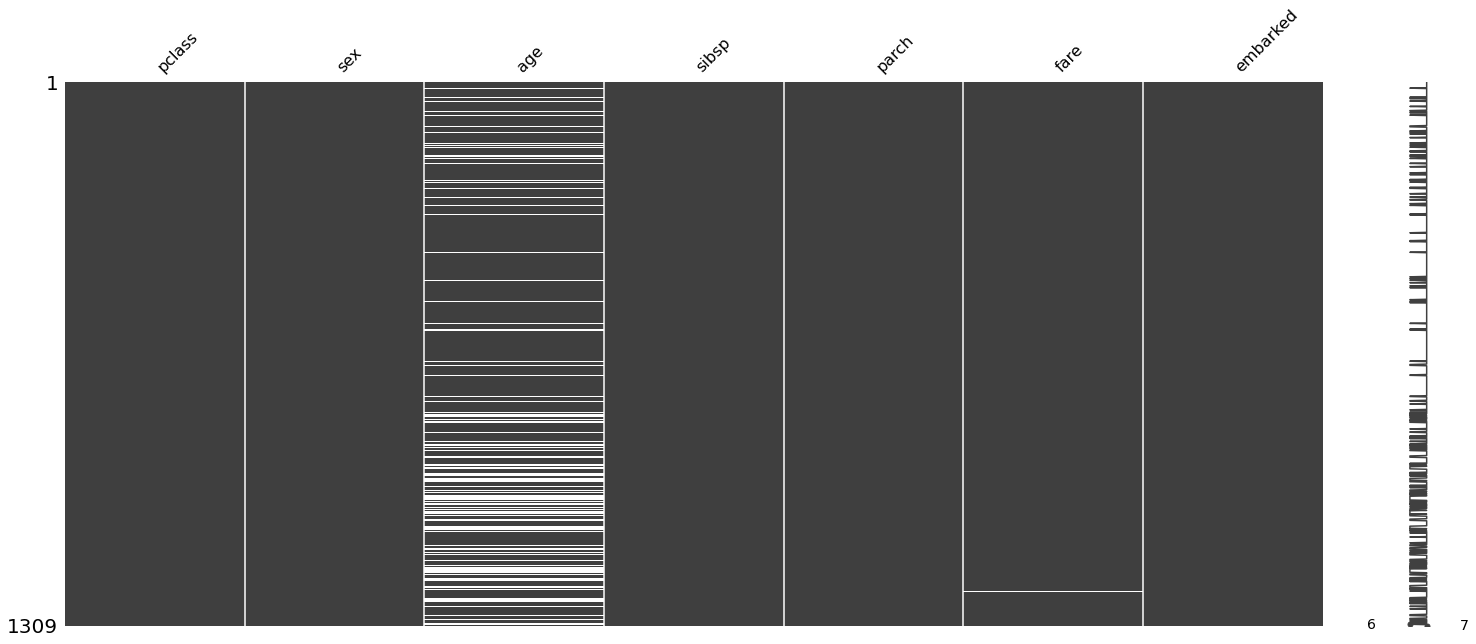

In [12]:
mn.matrix(df);

In [13]:
df.select_dtypes('object')

sex embarked
0     female        S
1       male        S
2     female        S
3       male        S
4     female        S
...      ...      ...
1304  female        C
1305  female        C
1306    male        C
1307    male        C
1308    male        S

[1309 rows x 2 columns]

In [14]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

#### Convert categorical values

In [15]:
df = pd.get_dummies(df, drop_first=True)

In [16]:
df.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_Q',
       'embarked_S'],
      dtype='object')

#### Impute missing values

In [17]:
imputer = IterativeImputer()

In [18]:
df.loc[:, :] = imputer.fit_transform(df)

In [19]:
df.head()

pclass      age  sibsp  parch      fare  sex_male  embarked_Q  embarked_S
0     1.0  29.0000    0.0    0.0  211.3375       0.0         0.0         1.0
1     1.0   0.9167    1.0    2.0  151.5500       1.0         0.0         1.0
2     1.0   2.0000    1.0    2.0  151.5500       0.0         0.0         1.0
3     1.0  30.0000    1.0    2.0  151.5500       1.0         0.0         1.0
4     1.0  25.0000    1.0    2.0  151.5500       0.0         0.0         1.0

In [20]:
df.isnull().sum().sum()

0

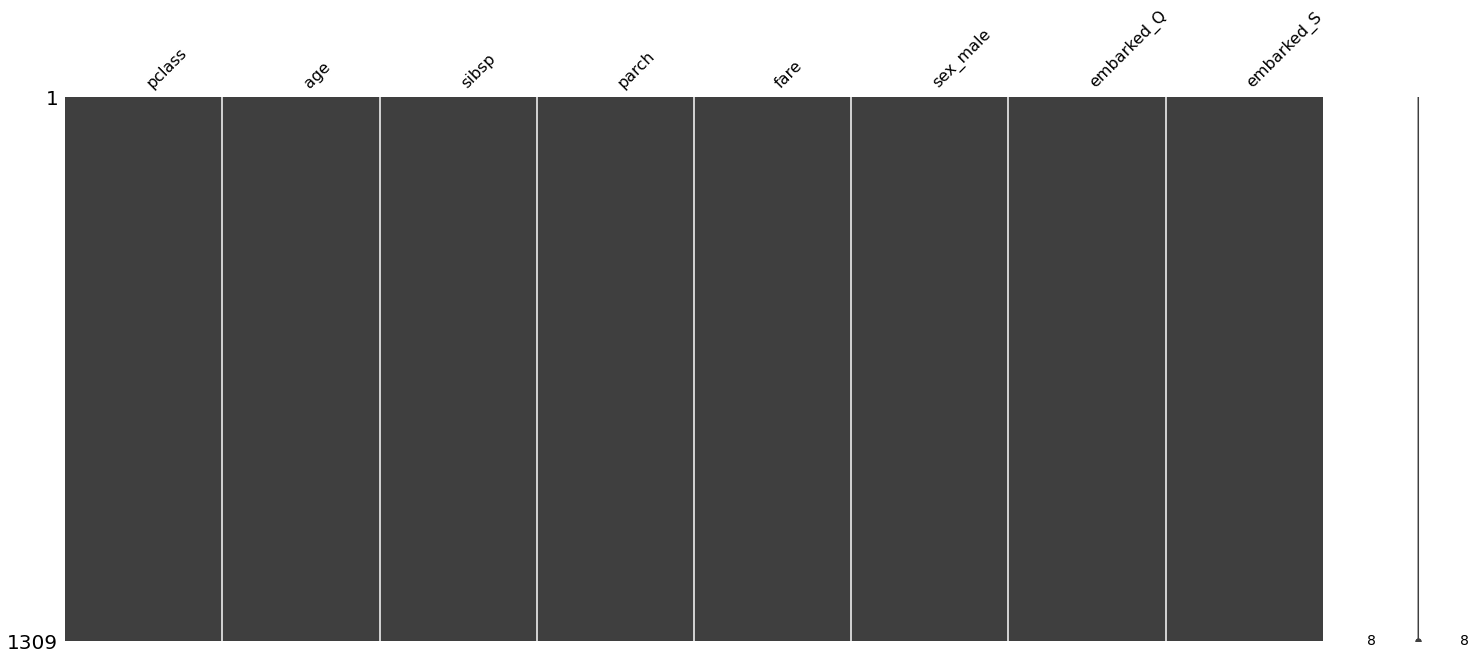

In [21]:
mn.matrix(df);

In [22]:
scaler = StandardScaler()

In [23]:
df.loc[:, :] = scaler.fit_transform(df)

In [24]:
df.head()

pclass       age     sibsp     parch      fare  sex_male  embarked_Q  \
0 -1.546098 -0.032047 -0.479087 -0.445000  3.442383 -1.344995    -0.32204   
1 -1.546098 -2.134080  0.481288  1.866526  2.286588  0.743497    -0.32204   
2 -1.546098 -2.052995  0.481288  1.866526  2.286588 -1.344995    -0.32204   
3 -1.546098  0.042803  0.481288  1.866526  2.286588  0.743497    -0.32204   
4 -1.546098 -0.331447  0.481288  1.866526  2.286588 -1.344995    -0.32204   

   embarked_S  
0    0.657394  
1    0.657394  
2    0.657394  
3    0.657394  
4    0.657394

## Dimension reduction

### PCA

If your knowledge of PCA is fading, see the notebook `B03A_PCA.ipynb`

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA()

In [27]:
X = pca.fit_transform(df)

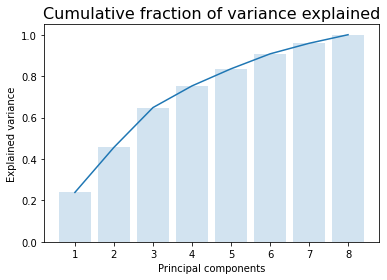

In [28]:
y = np.cumsum(pca.explained_variance_ratio_)
x = np.arange(1, len(y)+1)
plt.bar(x, y, alpha = 0.2)
plt.plot(x, y)
plt.xlabel('Principal components')
plt.ylabel('Explained variance')
plt.title('Cumulative fraction of variance explained', fontsize=16);

In [29]:
X.shape

(1309, 8)

In [30]:
df_orig.survived

0       1
1       1
2       0
3       0
4       0
       ..
1304    0
1305    0
1306    0
1307    0
1308    0
Name: survived, Length: 1309, dtype: int64

In [31]:
df_X = pd.DataFrame(X[:, :4], columns = [f'PC{i}' for i in range(1, 5)])
df_X['survived'] = df_orig.survived

In [32]:
import seaborn as sns

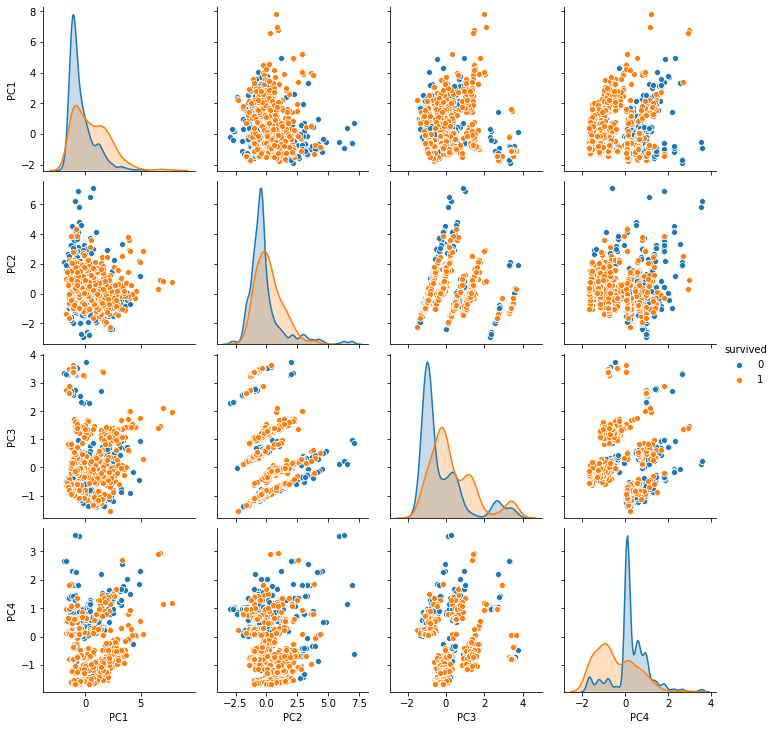

In [33]:
sns.pairplot(df_X, hue='survived');

In [34]:
df.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_Q',
       'embarked_S'],
      dtype='object')

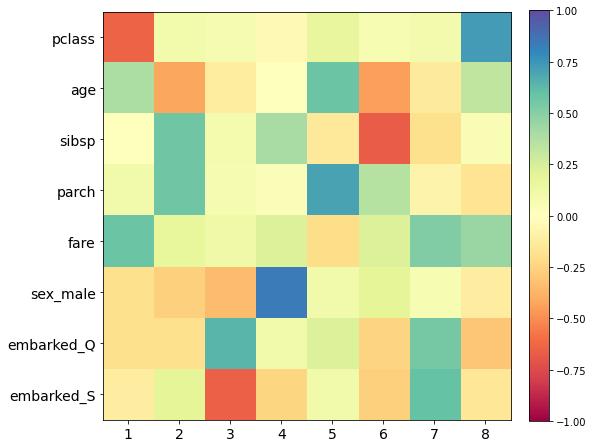

In [35]:
plt.figure(figsize=(8,8))
plt.imshow(pca.components_.T, cmap='Spectral', vmin=-1, vmax=1)
plt.colorbar(fraction=0.046, pad=0.04)
plt.yticks(range(len(df.columns)), df.columns, fontsize=14);
plt.xticks(range(len(df.columns)), 1+np.arange(len(df.columns)), fontsize=14);

In [36]:
from yellowbrick.features import PCA as PCA_

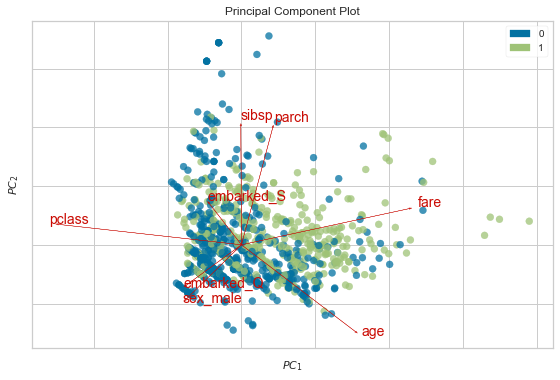

In [37]:
plt.rcParams['font.size'] = 14
pca_viz = PCA_(scale=True, proj_features=True)
pca_viz.fit_transform(df, df_orig.survived)
pca_viz.show();

### Interpreting the biplot

Bi = PCA plot + loadings plot

Each PC is just a linear combination of the original variables. 

$$
v = \alpha_1 x_1 + \alpha_2 x_2 + \ldots + \alpha_n x_n
$$

The coefficients $\alpha_i$ are known as *loadings* for each PC. This is stored in the `components_` attribute of the `sklearn` PCA instance. The loadings plot shows the contributions of the original features onto the PC axes. Here we show how `pclass` and `page` are projected as arrows onto the first 2 PC axes to make the process explicit.

- Arrows that point in the same direction indicate that the corresponding features are positively correlated
- Arrows that point in the opposite direction that the corresponding features are negatively correlated
- Arrows that are orthogonal that the corresponding features are uncorrelated

In [38]:
loadings = pd.DataFrame(pca.components_.T, columns = df.columns)
loadings

pclass       age     sibsp     parch      fare  sex_male  embarked_Q  \
0 -0.635912  0.097772  0.068619 -0.033886  0.171127  0.061837    0.091351   
1  0.396012 -0.415742 -0.121860 -0.004035  0.579482 -0.441761   -0.130143   
2 -0.002109  0.570101  0.082058  0.405007 -0.146939 -0.667134   -0.187980   
3  0.108994  0.562594  0.073326  0.037057  0.703756  0.366590   -0.077139   
4  0.582783  0.173223  0.117102  0.228776 -0.207883  0.230598    0.518714   
5 -0.193497 -0.262061 -0.340069  0.843517  0.106354  0.198993    0.059173   
6 -0.192757 -0.194293  0.641248  0.106013  0.229891 -0.248139    0.547727   
7 -0.112580  0.199099 -0.654043 -0.241523  0.103325 -0.259269    0.600716   

   embarked_S  
0    0.733993  
1    0.327990  
2    0.047117  
3   -0.171017  
4    0.445929  
5   -0.110924  
6   -0.297035  
7   -0.151074

In [39]:
x1, y1 = loadings.pclass[:2]
x2, y2 = loadings.age[:2]

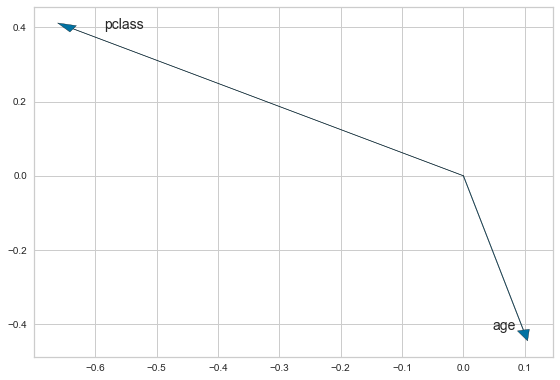

In [40]:
plt.arrow(0,0,x1,y1, head_width=0.02)
plt.arrow(0,0,x2,y2, head_width=0.02)
plt.text(x1 + 0.05, y1, loadings.columns[0])
plt.text(x2 - 0.05, y2, loadings.columns[1])
plt.tight_layout()

We expect these to be negatively correlated since they point in approximately opposite directions.

In [41]:
df.corr().iloc[:2, :2]

pclass       age
pclass  1.000000 -0.439092
age    -0.439092  1.000000

## Other dimension reduction methods

### PCA does not preserve local structure

## Limitations of PCA

We will project a 2-d data set onto 1-d to see one limitation of PCA. This provides motivation for learning non-linear methods of dimension reduction.

In [42]:
x1 = np.random.multivariate_normal([-3,3], np.eye(2), 100)
x2 = np.random.multivariate_normal([3,3], np.eye(2), 100)
x3 = np.random.multivariate_normal([0,-10], np.eye(2), 100)
xs = np.r_[x1, x2, x3]
xs = (xs - xs.mean(0))/xs.std()
zs = np.r_[np.zeros(100), np.ones(100), 2*np.ones(100)]

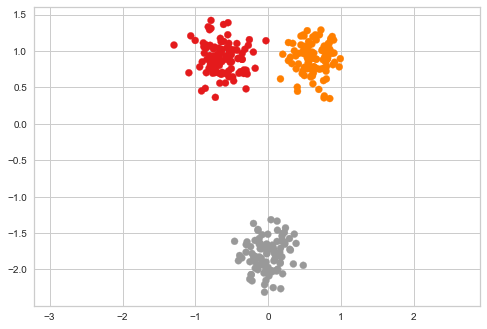

In [43]:
plt.scatter(xs[:, 0], xs[:, 1], c=zs, cmap='Set1')
plt.axis('equal')
pass

In [44]:
pca = PCA(n_components=1)

In [45]:
ys = pca.fit_transform(xs)

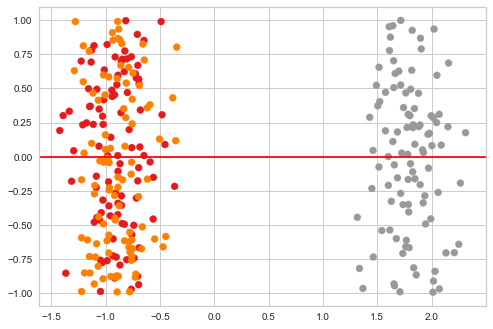

In [46]:
plt.scatter(ys[:, 0], np.random.uniform(-1, 1, len(ys)), c=zs, cmap='Set1')
plt.axhline(0, c='red')
pass

### T-SNE preserves locality

The t-SNE algorithm was designed to preserve local distances between points in the original space, as we saw in the example above. This means that t-SNE is particularly effective at preserving **clusters** in the original space. The full t-SNE algorithm is quite complex, so we just sketch the ideas here.

For more details, see the original [series of papers](https://lvdmaaten.github.io/tsne/) and this Python [tutorial](https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm). The algorithm is also clearly laid out in the fairly comprehensive [tutorial](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/).

### Outline of t-SNE

t-SNE is similar in outline to MDS, with two main differences - "distances" are baased on probabilistic concepts and depend on the local neighborhood of the point.

#### Original space

- Find the conditinoal similarity between points in the original space based on a Gaussian kernel

$$
p_{j \mid i} = \frac{f(\vert y_i - y_j \vert)}{\sum_{k \ne i} {f(\vert y_i - y_k \vert)}}
$$

where

$$
f(z) = {e^\frac{{-z^2}}{2\sigma_i^2}}
$$

- Symmetize the conditional similarity (this is necessary becasue each kernel has its own variance)

$$
p_{ij} = \frac{p_{i \mid j} + p_{j \mid i}}{2}
$$

- This gives a similarity matrix $p_{ij}$ that is fixed

Notes

- In t-SNE, the variance of the Gaussian kernel depensd on the point $x_i$. Intuitively, we want the variance to be small if $x_i$ is in a locally desnse region, and to be large if $x_i$ is in a locally sparse region. This is done by an iteratvie algorithm that depends on a user-defined variable called **perplexity**. Roughly, perplexity determines the number of meaningful neighbors each point should have.

#### Map space

- Find the conditional similarity between points in the map space based on a Cauchy kernel

$$
q_{ij} = \frac{g(\vert y_i - y_j \vert)}{\sum_{k \ne i} {g(\vert y_i - y_k \vert)}}
$$

where

$$
g(z) = \frac{1}{1+z^2}
$$

- This gives a similarity matrix $q_{ij}$ that depends on the points in the map space that we can vary

#### Optimization

- Minimize the Kullback-Leibler divergence between $p_{ij}$ and $q_{ij}$

$$
\text{KL}(P \mid\mid  Q) = \sum p_{ij} \log{\frac{p_{ij}}{q_{ij}}}
$$

#### Normal and Cauhcy distributions

The Cauchy has much fatter tails than the normal distribution.  This means that two points that are widely separated in the original space would be pushed much further apart in the map space.

In [47]:
! python3 -m pip install --quiet fitsne

In [48]:
import fitsne

In [49]:
ys = fitsne.FItSNE(xs)

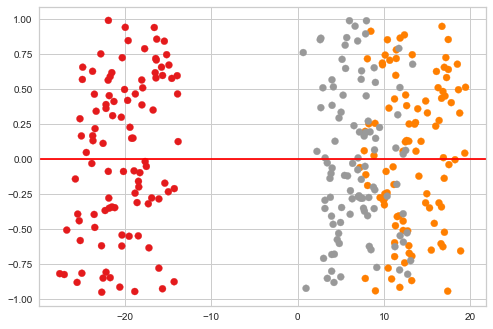

In [50]:
plt.scatter(ys[:, 0], np.random.uniform(-1, 1, len(ys)), c=zs, cmap='Set1')
plt.axhline(0, c='red')
pass

### Illustrating with MNIST digits

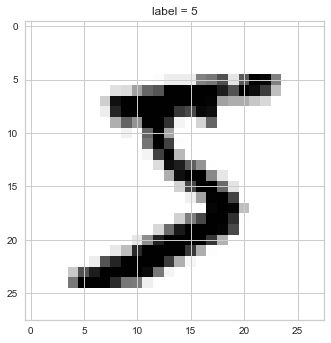

In [51]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
plt.imshow(X[0].reshape((28,28)), cmap='binary')
plt.title(f'label = {y[0]}');

In [52]:
%%capture
sc = plt.scatter(np.arange(10), np.arange(10), c=np.arange(10), cmap='tab10')

In [53]:
%%time
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

CPU times: user 11.3 s, sys: 2.27 s, total: 13.6 s
Wall time: 1.91 s


In [63]:
import warnings
warnings.simplefilter('ignore', UserWarning)

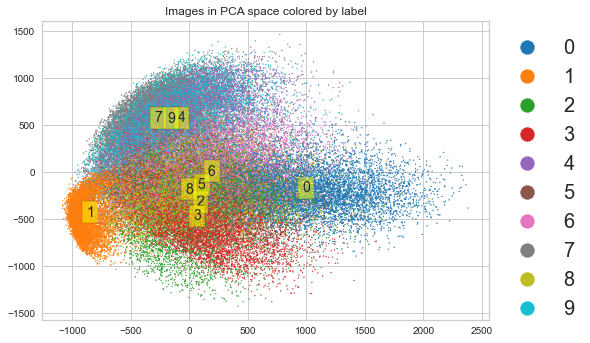

In [65]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1, 
            c=y.astype('int'), cmap='tab10')
plt.title('Images in PCA space colored by label')
for i in range(10):
    idx = y == i
    μ = np.mean(X_pca[y == i], axis=0)
    plt.text(*μ, str(i), va='center', ha='center', 
             bbox=dict(facecolor='yellow', alpha=0.5))
plt.legend(*sc.legend_elements(), 
           bbox_to_anchor=(1,1), 
           fontsize=20, 
           markerscale=2);

### t-SNE preserves local structure

In [55]:
X.shape

(70000, 784)

In [56]:
import fitsne

In [57]:
%%time
X = X.copy(order='C')
X_tsne = fitsne.FItSNE(X)

CPU times: user 13min 3s, sys: 7.3 s, total: 13min 10s
Wall time: 2min 10s


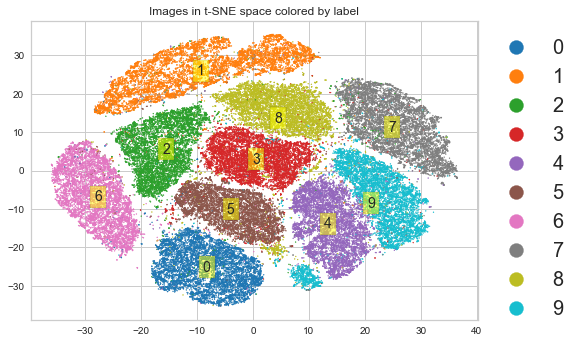

In [64]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=1, 
            c=y.astype('int'), cmap='tab10')
plt.title('Images in t-SNE space colored by label')
for i in range(10):
    idx = y == i
    μ = np.mean(X_tsne[y == i], axis=0)
    plt.text(*μ, str(i), va='center', ha='center', 
             bbox=dict(facecolor='yellow', alpha=0.5))
plt.legend(*sc.legend_elements(), 
           bbox_to_anchor=(1,1), 
           fontsize=20, 
           markerscale=2);

### UMAP preserves local and (maybe) global structure

Normally I would refer you to the [original paper](https://arxiv.org/pdf/1802.03426). But the original paper is hard to read unless you have graduate training in pure mathematics, so visit this [tutorial](https://pair-code.github.io/understanding-umap/) instead.

In [59]:
import umap

In [60]:
%%time
X_umap = umap.UMAP().fit_transform(X)

CPU times: user 3min 38s, sys: 5.51 s, total: 3min 44s
Wall time: 1min 12s


In [61]:
y = y.astype('int')

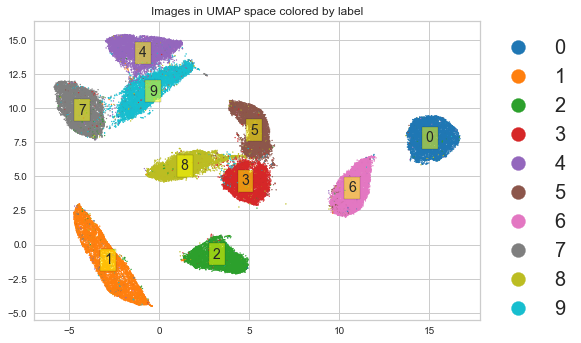

In [62]:
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=1, 
            c=y, cmap='tab10')
plt.title('Images in UMAP space colored by label')
for i in range(10):
    idx = y == i
    μ = np.mean(X_umap[y == i], axis=0)
    plt.text(*μ, str(i), va='center', ha='center', 
             bbox=dict(facecolor='yellow', alpha=0.5))
plt.legend(*sc.legend_elements(), 
           bbox_to_anchor=(1,1), 
           fontsize=20, 
           markerscale=2);